# Homework:
# Deep Convolutional Generative Adversarial Network 

Description of an implementation of DCGAN can be found in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

In [1]:
#Import the libraries we will need.
import tensorflow as tf
import tqdm
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically.

In [2]:
mnist = input_data.read_data_sets('fashion-mnist/data/fashion', one_hot=False)

Extracting fashion-mnist/data/fashion/train-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz


### Helper Functions

In [3]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

## Defining the Adversarial Networks

### Generator Network

In [4]:
def generator(z):
    zP = slim.fully_connected(z,4*4*256,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,256])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    
    return g_out

### Discriminator Network

### Task1 (13 points)
Fill parameter for the discrimiator architecture

In [5]:
def discriminator(bottom, reuse=False):
    with slim.arg_scope([slim.fully_connected, slim.convolution2d], reuse=reuse, weights_initializer=initializer):
        dis1 = slim.convolution2d(bottom, scope='d_conv1', num_outputs=16,
                                  kernel_size=[5, 5], padding="SAME", 
                                  normalizer_fn=slim.batch_norm, activation_fn=lrelu)

        dis2 = slim.convolution2d(dis1, scope='d_conv2', num_outputs=32,
                                  kernel_size=[5, 5], stride=[2, 2],
                                  padding="SAME", normalizer_fn=slim.batch_norm, 
                                  activation_fn=lrelu)

        dis3 = slim.convolution2d(dis2, scope='d_conv3', num_outputs=64,
                                  kernel_size=[5, 5], stride=[2, 2], 
                                  padding="SAME", normalizer_fn=slim.batch_norm, 
                                  activation_fn=lrelu)
        
        dis4 = slim.convolution2d(dis3, scope='d_conv4', num_outputs=128,
                                  kernel_size=[5, 5], stride=[2, 2], padding="SAME",
                                  normalizer_fn=slim.batch_norm, activation_fn=lrelu)
        
        d_out = slim.fully_connected(slim.flatten(dis4), scope='d_out', 
                                     num_outputs=1, activation_fn=tf.nn.sigmoid, 
                                     weights_initializer=initializer)
                                     
    return d_out

### Connecting them together

In [6]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images


#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

## Training the network
I strongly advise you to skip this cell and go the the next one since training will take you enormous amount of time

In [7]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 500000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    for i in tqdm.tqdm_notebook(range(iterations)):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 10 == 0: 
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

Widget Javascript not detected.  It may not be installed or enabled properly.


Gen Loss: 0.564625 Disc Loss: 1.27914
Gen Loss: 0.740345 Disc Loss: 1.99015
Gen Loss: 1.24719 Disc Loss: 1.51429
Gen Loss: 2.15557 Disc Loss: 0.789321
Gen Loss: 1.6379 Disc Loss: 1.46493
Gen Loss: 2.36797 Disc Loss: 0.974535
Gen Loss: 2.12971 Disc Loss: 1.80872
Gen Loss: 1.91726 Disc Loss: 1.58629
Gen Loss: 1.59167 Disc Loss: 0.900938
Gen Loss: 1.75992 Disc Loss: 1.02458
Gen Loss: 1.47976 Disc Loss: 0.86475
Gen Loss: 1.71782 Disc Loss: 0.718296
Gen Loss: 2.13782 Disc Loss: 0.613305
Gen Loss: 2.51764 Disc Loss: 0.798337
Gen Loss: 1.65068 Disc Loss: 0.655746
Gen Loss: 2.15268 Disc Loss: 0.529501
Gen Loss: 1.36345 Disc Loss: 0.782065
Gen Loss: 1.76479 Disc Loss: 0.587499
Gen Loss: 3.44534 Disc Loss: 0.73005
Gen Loss: 2.2702 Disc Loss: 0.604302
Gen Loss: 3.35035 Disc Loss: 0.150696
Gen Loss: 2.29616 Disc Loss: 0.392554
Gen Loss: 3.34761 Disc Loss: 0.31526
Gen Loss: 3.9101 Disc Loss: 0.0748567
Gen Loss: 1.36194 Disc Loss: 0.257263
Gen Loss: 2.59053 Disc Loss: 0.490398
Gen Loss: 2.91366 Disc

Gen Loss: 1.92051 Disc Loss: 0.331426
Gen Loss: 1.69991 Disc Loss: 0.308055
Gen Loss: 0.782882 Disc Loss: 1.50221
Gen Loss: 2.72562 Disc Loss: 0.494593
Gen Loss: 2.75386 Disc Loss: 0.220385
Gen Loss: 3.01073 Disc Loss: 0.489476
Gen Loss: 2.13449 Disc Loss: 0.344153
Gen Loss: 2.72425 Disc Loss: 0.477243
Gen Loss: 2.3309 Disc Loss: 0.341873
Gen Loss: 2.66523 Disc Loss: 0.256782
Gen Loss: 1.58822 Disc Loss: 0.835049
Gen Loss: 0.76848 Disc Loss: 0.238643
Gen Loss: 3.40578 Disc Loss: 0.467231
Gen Loss: 2.27835 Disc Loss: 0.368069
Gen Loss: 5.90252 Disc Loss: 0.69888
Gen Loss: 1.27227 Disc Loss: 0.74139
Gen Loss: 1.95852 Disc Loss: 0.518093
Gen Loss: 2.1907 Disc Loss: 0.520672
Gen Loss: 2.66277 Disc Loss: 0.351349
Gen Loss: 1.374 Disc Loss: 0.489211
Gen Loss: 2.15259 Disc Loss: 0.544119
Gen Loss: 2.13021 Disc Loss: 0.315722
Gen Loss: 2.4006 Disc Loss: 0.35948
Gen Loss: 2.67619 Disc Loss: 0.318424
Gen Loss: 2.30511 Disc Loss: 0.486682
Gen Loss: 3.22856 Disc Loss: 0.260125
Gen Loss: 7.66428 Di

Gen Loss: 2.56561 Disc Loss: 0.183536
Gen Loss: 3.35017 Disc Loss: 0.265374
Gen Loss: 2.87639 Disc Loss: 0.214139
Gen Loss: 4.22725 Disc Loss: 0.221296
Gen Loss: 5.20471 Disc Loss: 0.297145
Gen Loss: 3.41635 Disc Loss: 0.123128
Gen Loss: 3.72994 Disc Loss: 0.0669656
Gen Loss: 3.07744 Disc Loss: 0.175666
Gen Loss: 3.17382 Disc Loss: 0.0993553
Gen Loss: 2.07679 Disc Loss: 0.254548
Gen Loss: 5.37261 Disc Loss: 0.356317
Gen Loss: 3.50362 Disc Loss: 0.164372
Gen Loss: 3.86144 Disc Loss: 0.236815
Gen Loss: 1.50939 Disc Loss: 0.248538
Gen Loss: 3.13616 Disc Loss: 0.221507
Gen Loss: 2.24541 Disc Loss: 0.463886
Gen Loss: 3.14606 Disc Loss: 0.284452
Gen Loss: 1.17139 Disc Loss: 0.0819349
Gen Loss: 5.19064 Disc Loss: 0.384261
Gen Loss: 3.45809 Disc Loss: 0.226095
Gen Loss: 2.7838 Disc Loss: 0.283597
Gen Loss: 2.76624 Disc Loss: 0.299458
Gen Loss: 3.10337 Disc Loss: 0.140346
Gen Loss: 2.79304 Disc Loss: 0.159188
Gen Loss: 2.79836 Disc Loss: 0.142834
Gen Loss: 3.3819 Disc Loss: 0.170751
Gen Loss: 1

Gen Loss: 5.6524 Disc Loss: 0.151292
Gen Loss: 3.89483 Disc Loss: 0.118637
Gen Loss: 3.28015 Disc Loss: 0.0956236
Gen Loss: 3.1038 Disc Loss: 0.100689
Gen Loss: 3.27578 Disc Loss: 0.0921635
Gen Loss: 3.51649 Disc Loss: 0.114802
Gen Loss: 3.49099 Disc Loss: 0.113083
Gen Loss: 2.57808 Disc Loss: 0.16921
Gen Loss: 3.32895 Disc Loss: 0.187755
Gen Loss: 2.41758 Disc Loss: 0.128444
Gen Loss: 4.4423 Disc Loss: 0.207484
Gen Loss: 3.15709 Disc Loss: 0.154883
Gen Loss: 3.07746 Disc Loss: 0.149246
Gen Loss: 1.83112 Disc Loss: 0.168082
Gen Loss: 5.61665 Disc Loss: 0.227868
Gen Loss: 7.27854 Disc Loss: 0.278523
Gen Loss: 3.13636 Disc Loss: 0.0439358
Gen Loss: 2.16522 Disc Loss: 0.145151
Gen Loss: 3.85197 Disc Loss: 0.0608563
Gen Loss: 4.88589 Disc Loss: 0.0540174
Gen Loss: 4.75121 Disc Loss: 0.0634622
Gen Loss: 4.15148 Disc Loss: 0.0458548
Gen Loss: 3.64053 Disc Loss: 0.146439
Gen Loss: 3.18938 Disc Loss: 0.104549
Gen Loss: 7.21518 Disc Loss: 0.636701
Gen Loss: 3.04527 Disc Loss: 0.191215
Gen Loss:

KeyboardInterrupt: 

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [8]:
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 36

path = model_directory  + '/model-7000.cptk'

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print( 'Loading Model...')
    saver.restore(sess, save_path=path)
    #     ckpt = tf.train.get_checkpoint_state(model_directory)
    #     saver.restore(sess,ckpt.model_checkpoint_path)
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/fig.png')

Loading Model...
INFO:tensorflow:Restoring parameters from ./models/model-7000.cptk


### Task 2 (2 points)
Run a couple of iterations and visualize examples generated by the generator (Could be found in ./fig folder)

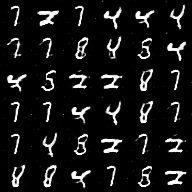

In [9]:
from IPython.display import Image
Image(filename='figs/fig.png') 

### Task 3 (5 points)
Evaluate discrimator accuracy in the pre-trained model on any representative subsample of fashion-minst

In [ ]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 1000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.

path = model_directory + '/model-7000.cptk'

init = tf.global_variables_initializer()
saver = tf.train.Saver()
r = 0
cnt_rght=0
cnt_wrng=0
with tf.Session() as sess:  
    sess.run(init)
    saver.restore(sess, save_path=path)
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.test.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        
        
        dx, dg = sess.run([Dx, Dg],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        res = sess.run(Dx, feed_dict={real_in: xs})
        print(dx)
        r += (dx >= 0.1)
        r += (dg <= 0.1)
        print('l', len(dx))
        print(cnt_rght)

        for j in range(len(dx)):
            if dx[j] > 0.1:
                cnt_rght += 1
            else:
                cnt_wrng += 1
        
        for j in range(len(dg)):
            if dg[j] < 0.1:
                cnt_rght += 1
            else:
                cnt_wrng += 1
        print(cnt_rght)

        if i % 100 == 0:
            print("accuracy = ", cnt_rght/(cnt_rght + cnt_wrng), r/batch_size)